In [44]:
# from https://code.datasciencedojo.com/datasciencedojo/datasets/tree/master/Blood%20Transfusion%20Service%20Center

import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer

import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set a random seed
# np.random.seed(42)

### Data load

In [45]:
# data_df = pd.read_csv('./transfusion.data.csv')
data_df = pd.read_csv('./data_banknote_authentication.txt', header=None)

In [46]:
X = np.array(data_df[data_df.columns[:-1]], requires_grad = False)
y = np.array(data_df[data_df.columns[-1:]], requires_grad = False).reshape((-1,))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Useful functions

In [47]:
def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

In [48]:
# Define output labels as quantum state vectors
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T

### Quantum circuits

In [49]:
def U_SU4(params, wires):  # General circuit for 2 qubits, 15 params
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])

def Pooling_ansatz1(params, wires): #2 params
    qml.CRZ(params[0], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRX(params[1], wires=[wires[0], wires[1]])

In [67]:
dev = qml.device("lightning.qubit", wires=4)
@qml.qnode(dev, interface="autograd", diff_method ="adjoint")
def QCNN(params, x, M):
    p1 = params[0:15]
    p2 = params[15:17]
    p3 = params[17:32]
    p4 = params[32:34]
    
    qml.RY(x[0], wires=0)
    qml.RY(x[1], wires=1)
    qml.RY(x[2], wires=2)
    qml.RY(x[3], wires=3)
    
    U_SU4(p1, [0,1])
    U_SU4(p1, [2,3])
    Pooling_ansatz1(p2, [1,0])
    Pooling_ansatz1(p2, [3,2])
    U_SU4(p3, [0,2])
    Pooling_ansatz1(p4, [0,2])
    
    return qml.expval(qml.Hermitian(M, wires=[2]))

dev = qml.device("lightning.qubit", wires=4)
# dev = qml.device("qiskit.aer", wires = 4)
@qml.qnode(dev, interface="autograd", diff_method="adjoint")
def QCNN_reuploading(params, x, M):
    p1 = params[0:15]
    p2 = params[15:17]
    p3 = params[17:32]
    p4 = params[32:34]
    
    qml.RY(x[0], wires=0)
    qml.RY(x[1], wires=1)
    qml.RY(x[2], wires=2)
    qml.RY(x[3], wires=3)
    
    U_SU4(p1, [0,1])
    U_SU4(p1, [2,3])
    Pooling_ansatz1(p2, [1,0])
    Pooling_ansatz1(p2, [3,2])
    
    qml.Rot(x[0], x[1], 0, wires = 0)
    qml.Rot(x[2], x[3], 0, wires = 2)
    
    U_SU4(p3, [0,2])
    Pooling_ansatz1(p4, [0,2])

    return qml.expval(qml.Hermitian(M, wires=[2]))

d:\Documents\1. GitHub\cuco\venv\lib\site-packages\qiskit\visualization\circuit\circuit_visualization.py:296: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  image.show()


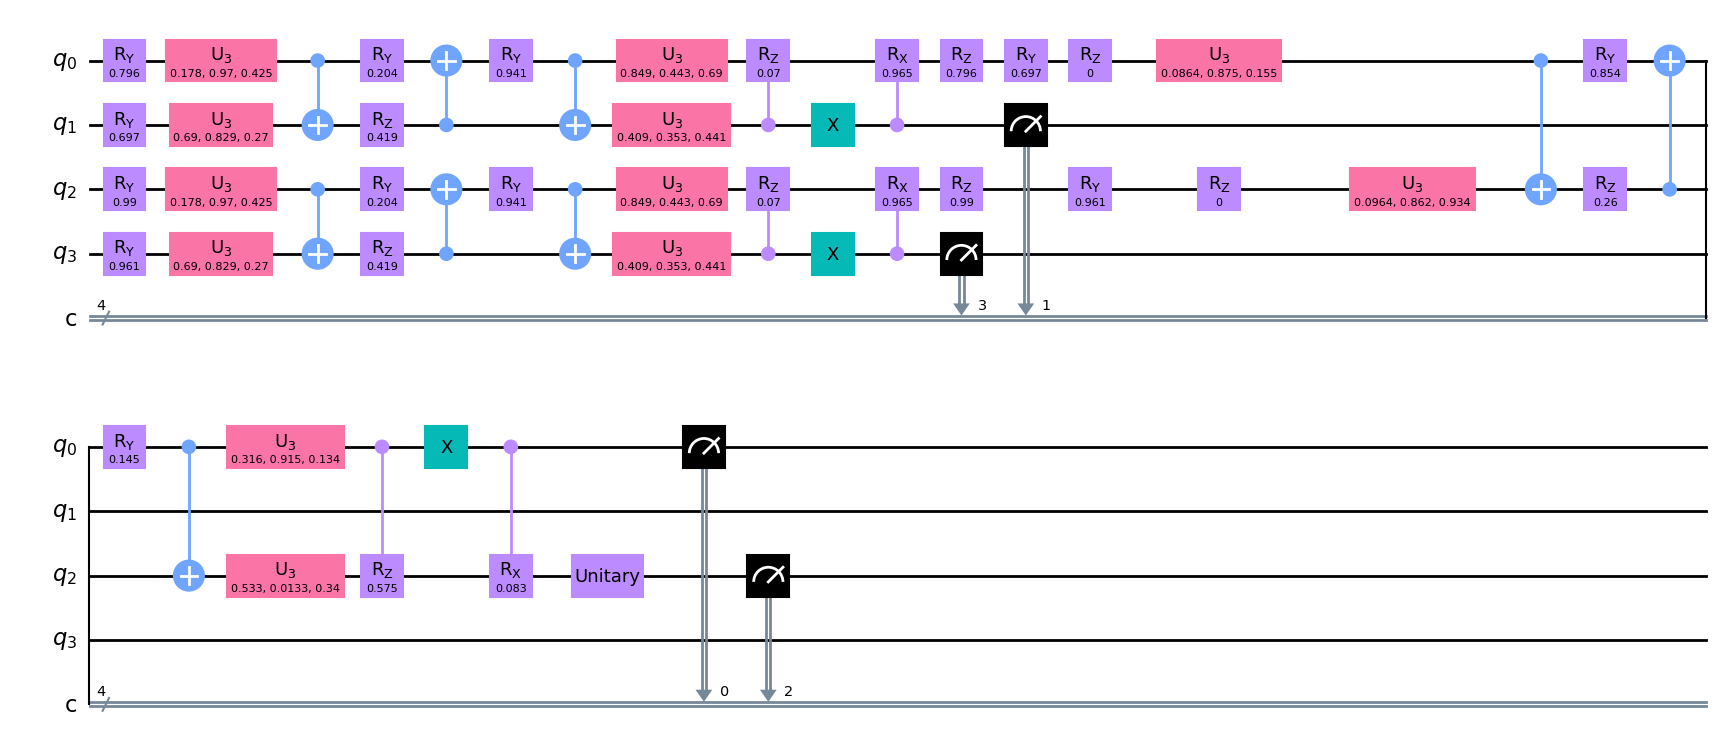

In [66]:
# Only use in order to see the picture of the circuits. Proper changes should be made in the definition of the circuits (device = "qiskit.aer").

# params = np.random.uniform(size=(51))
# x =  np.random.uniform(size=(4))
# resultat = QCNN_reuploading(params, x, [[1,0],[0,0]])

# dev._circuit.draw(output ="mpl", interactive = True)

### Cost

In [51]:
def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    # print(dm_labels) #!------------------------------------------------------------------------ Mirar si surt 3D: no, surt bé --------------------------
    for i in range(len(x)):
        f = QCNN(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2  #!-------------------------------------------------------- usem cross entropy? ------------------------
    return loss / len(x)

### Test and accuracy

In [52]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_real, y_pred):
    TP = sum(y_real * y_pred)
    FP = sum(np.logical_not(y_real) * y_pred)
    TN = sum(np.logical_not(y_real) * np.logical_not(y_pred))
    FN = sum(y_real * np.logical_not(y_pred))

    accuracy = (TP+TN)/(TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2*precision*recall / (precision + recall)
    specificity = TN/(TN+FP)

    return accuracy, precision, recall, F1, specificity

### Execution

In [69]:
# Train using Adam optimizer and evaluate the classifier
qcircuit = QCNN_reuploading # QCNN or QCNN_reuploading
learning_rate = 0.05
epochs = 10
batch_size = 30

label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)

# print(state_labels)
opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
if qcircuit == QCNN:
    params = np.random.uniform(size=(51), requires_grad=True)
    circuit_name = "QCNN"

elif qcircuit == QCNN_reuploading:
    params = np.random.uniform(size=(51), requires_grad=True)
    circuit_name = "QCNN_reuploading"

cost_history = []
for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        variables, cost_value = opt.step_and_cost(cost, params, Xbatch, ybatch, state_labels)
        params = variables[0]
        
    print(f'Epoch: {it + 1} | Cost: {cost_value}')
    cost_history.append(float(cost_value))
    
predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy, precision, recall, F1, specificity = accuracy_score(y_test, predicted_test)

print(f"{circuit_name}, epochs = {epochs}, accuracy = {accuracy*100:.2f}%, precision = {precision*100:.2f}%, recall = {recall*100:.2f}%, F1 = {F1*100:.2f}%, specificity = {specificity*100:.2f}%")

with open('Results/results.txt', 'a') as f:
    f.write(datetime.now().strftime("%d/%m/%Y %H:%M:%S") + "\n")
    f.write(f"Cost History for {circuit_name}, epochs = {epochs}, accuracy = {accuracy*100:.2f}%, precision = {precision*100:.2f}%, recall = {recall*100:.2f}%, F1 = {F1*100:.2f}%, specificity = {specificity*100:.2f}%\n")
    f.write(str(cost_history) + "\n\n")


Epoch: 1 | Cost: 0.07212422391040813
Epoch: 2 | Cost: 0.0697632299771304
Epoch: 3 | Cost: 0.07235777673714265
Epoch: 4 | Cost: 0.07293863061967548
Epoch: 5 | Cost: 0.06955988666472482
Epoch: 6 | Cost: 0.06763242420446154
Epoch: 7 | Cost: 0.06784558883011498
Epoch: 8 | Cost: 0.06831990513619061
Epoch: 9 | Cost: 0.06865398461515536
Epoch: 10 | Cost: 0.0688440117374274
QCNN_reuploading, epochs = 10, accuracy = 64.72%, precision = 60.45%, recall = 67.72%, F1 = 63.88%, specificity = 62.16%
